In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import intvalpy as ip

In [2]:
df1 = pd.read_csv("inversion radius1.csv")
df2 = pd.read_csv("normalised_export.csv", encoding="cp1251")

shot = 43043

T1 = df1.loc[df1['shotn'] == shot, 'ts_time 1'].iloc[0]
T2 = df1.loc[df1['shotn'] == shot, 'ts_time 2'].iloc[0]

dff = df2[df2["shotn"] == shot]
dff['time'] = pd.to_numeric(dff['time'], errors='coerce')

df_all_values = dff[((dff["time"]) >= float(T1) ) & ((dff["time"]) <= float(T2) )]


C:\Users\Hanurik\AppData\Local\Temp\ipykernel_14696\2750694379.py:2: DtypeWarning: Columns (0,1,2,5,6,7,8,9,10,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("normalised_export.csv", encoding="cp1251")
C:\Users\Hanurik\AppData\Local\Temp\ipykernel_14696\2750694379.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['time'] = pd.to_numeric(dff['time'], errors='coerce')


In [3]:
BT_test = pd.to_numeric(df2["B_T"], errors='coerce').values
I_p_test = pd.to_numeric(df2["I_p"], errors='coerce').values
Bt_del_Ip_test = BT_test / I_p_test

In [8]:
mask1 = df_all_values["time"] == 164.23
df_time1 = df_all_values[mask1]

Te_1_mean = pd.to_numeric(df_time1["<Te>"], errors='coerce').values
Te_1_del = pd.to_numeric(df_time1["T_e/<Te>"], errors='coerce').values
Te_1 = Te_1_mean * Te_1_del

R_1 = pd.to_numeric(df_time1["R"], errors='coerce').values
R_1_interval = pd.to_numeric(df_time1["R-R_lcfs"], errors='coerce').values

BT_1 = pd.to_numeric(df_time1["B_T"], errors='coerce').values
I_p_1 = pd.to_numeric(df_time1["I_p"], errors='coerce').values

Bt_del_Ip_1 = BT_1 / I_p_1


mask_R1 = (R_1 >= 42.4) & (~np.isnan(R_1)) & (~np.isnan(Te_1))
R_1_filtered = R_1[mask_R1]
Te_1_filtered = Te_1[mask_R1]
Bt_del_Ip_1_filtered = Bt_del_Ip_1[mask_R1]


# 2
mask2 = df_all_values["time"] == 167.26
df_time2 = df_all_values[mask2]

Te_2_mean = pd.to_numeric(df_time2["<Te>"], errors='coerce').values
Te_2_del = pd.to_numeric(df_time2["T_e/<Te>"], errors='coerce').values
Te_2 = Te_2_mean * Te_2_del

R_2 = pd.to_numeric(df_time2["R"], errors='coerce').values
R_2_interval = pd.to_numeric(df_time2["R-R_lcfs"], errors='coerce').values


BT_2 = pd.to_numeric(df_time2["B_T"], errors='coerce').values
I_p_2 = pd.to_numeric(df_time2["I_p"], errors='coerce').values

Bt_del_Ip_2 = BT_2 / I_p_2


mask_R2 = (R_2 > 42.4) & (~np.isnan(R_2)) & (~np.isnan(Te_2))
R_2_filtered = R_2[mask_R2]
Te_2_filtered = Te_2[mask_R2]
Bt_del_Ip_2_filtered = Bt_del_Ip_2[mask_R2]


if len(R_1_filtered) == 0 or len(R_2_filtered) == 0:
    print("Внимание: один из фильтрованных массивов пуст!")
    print(f"R_1_filtered длина: {len(R_1_filtered)}")
    print(f"R_2_filtered длина: {len(R_2_filtered)}")
else:

    sort_idx1 = np.argsort(R_1_filtered)
    sort_idx2 = np.argsort(R_2_filtered)
    
    R_1_sorted = R_1_filtered[sort_idx1]
    Te_1_sorted = Te_1_filtered[sort_idx1]
    
    R_2_sorted = R_2_filtered[sort_idx2]
    Te_2_sorted = Te_2_filtered[sort_idx2]
    
    
    spline_1 = interp1d(R_1_sorted, Te_1_sorted, kind='linear', 
                        fill_value='extrapolate', bounds_error=False)
    spline_2 = interp1d(R_2_sorted, Te_2_sorted, kind='linear',
                        fill_value='extrapolate', bounds_error=False)
    

    R_min = min(R_1_sorted.min(), R_2_sorted.min())
    R_max = max(R_1_sorted.max(), R_2_sorted.max())
    
    R_grid = np.linspace(R_min, R_max, 1000)
    
    
    Te_1_interp = spline_1(R_grid)
    Te_2_interp = spline_2(R_grid)
    

    Te_1_lower = 0.95 * Te_1_interp  
    Te_1_upper = 1.05 * Te_1_interp  
    
    Te_2_lower = 0.95 * Te_2_interp  
    Te_2_upper = 1.05 * Te_2_interp  
    
    
    Te_1_original_lower = 0.95 * Te_1_sorted
    Te_1_original_upper = 1.05 * Te_1_sorted
    
    Te_2_original_lower = 0.95 * Te_2_sorted
    Te_2_original_upper = 1.05 * Te_2_sorted

In [9]:
def jaccard_coefficient_interval(interval1, interval2):

    a1, b1 = interval1
    a2, b2 = interval2
    
 
    a1, b1 = min(a1, b1), max(a1, b1)
    a2, b2 = min(a2, b2), max(a2, b2)
    

    intersection_start = max(a1, a2)
    intersection_end = min(b1, b2)
    

    if intersection_start > intersection_end:
        return 0.0
    

    union_start = min(a1, a2)
    union_end = max(b1, b2)
    

    intersection_length = intersection_end - intersection_start
    union_length = union_end - union_start
    

    if union_length == 0:
        return 1.0 if intersection_length == 0 else 0.0
    
    return intersection_length / union_length

In [10]:
Jaccart = []

for i in range(len(R_grid)):
    X = (0.95*Te_1_interp[i], 1.05*Te_1_interp[i])
    Y = (0.95*Te_2_interp[i], 1.05*Te_2_interp[i])
    jaccart = ( jaccard_coefficient_interval(X, Y))
    if jaccart < 0:
        jaccart = 0
    Jaccart.append(jaccart)


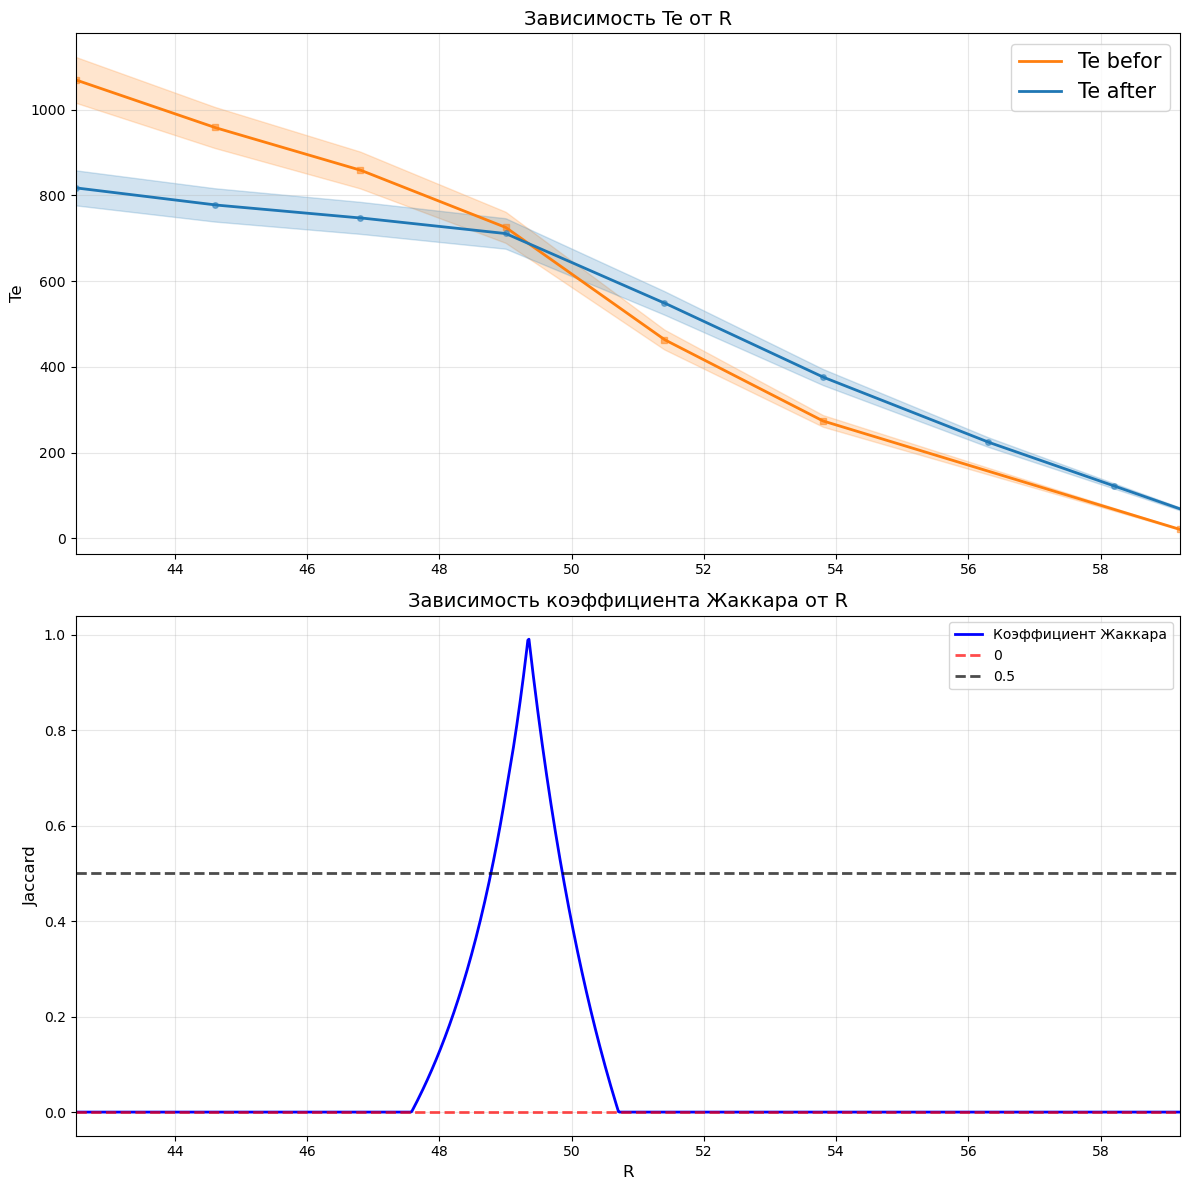

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))


ax1 = axes[0]


ax1.fill_between(R_grid, Te_1_lower, Te_1_upper, alpha=0.2, color='C1')
ax1.plot(R_grid, Te_1_interp, '-', color='C1', linewidth=2, label='Te befor')
ax1.plot(R_1_sorted, Te_1_sorted, 's', color='C1', alpha=0.5, markersize=4)
ax1.fill_between(R_grid, Te_2_lower, Te_2_upper, alpha=0.2, color='C0')


ax1.plot(R_grid, Te_2_interp, '-', color='C0', linewidth=2, label='Te after')
ax1.plot(R_2_sorted, Te_2_sorted, 'o', color='C0', alpha=0.5, markersize=4)

ax1.set_ylabel('Te', fontsize=12)
ax1.set_title('Зависимость Te от R', fontsize=14)
ax1.legend(loc='best', fontsize=15)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([min(R_grid), max(R_grid)])


ax2 = axes[1]
ax2.plot(R_grid, Jaccart, 'b-', linewidth=2, label='Коэффициент Жаккара')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2, alpha=0.7, label='0')
ax2.axhline(y=0.5, color='black', linestyle='--', linewidth=2, alpha=0.7, label='0.5')

ax2.set_xlabel('R', fontsize=12)
ax2.set_ylabel('Jaccard', fontsize=12)
ax2.set_title('Зависимость коэффициента Жаккара от R', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')
ax2.set_xlim([min(R_grid), max(R_grid)])

plt.tight_layout()
plt.show()